In [19]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import nltk
# nltk.download()
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

np.random.seed(1)




In [20]:
# ====================================== Load the data =============================================================
data = pd.read_csv('spam.csv', usecols = [0,1], encoding='latin-1')
data.columns = ['label', 'text']
data.head()


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [21]:
# ========================= Customized normalization of text developed by Kenneth ===================================
total_stopwords = set([word.replace("'",'') for word in stopwords.words('english')])
lemma = WordNetLemmatizer()
def preprocess_text(text):
    text = text.lower() # Convert to lowercase
    text = text.replace("'",'') #
    text = re.sub('[^a-zA-Z]',' ',text)
    words = text.split()
    words = [lemma.lemmatize(word) for word in words if (word not in total_stopwords) and (len(word)>1)] # Remove stop words
    text = " ".join(words)
    return text

data['text'] = data['text'].apply(preprocess_text)
data['text'].describe()

count                     5572
unique                    5046
top       sorry ill call later
freq                        30
Name: text, dtype: object

In [22]:
# ========================= features and labels definition ==========================================================
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(data['text']).toarray()

le = LabelEncoder()
y = le.fit_transform(data['label'])
# Seperate the data into training and testing session
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, shuffle = False)

In [23]:
# ========================= Random Forest classier starts ===========================================================
classifier=RandomForestClassifier(n_estimators=15,criterion='entropy')
classifier.fit(x_train,y_train)
y_pred=classifier.predict(x_test)
np.count_nonzero(y_pred)

98

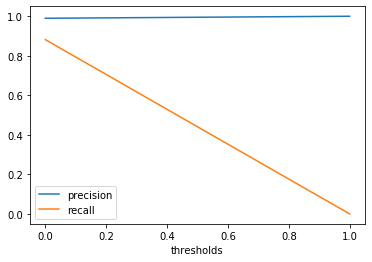

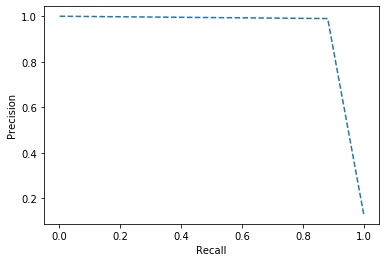

In [26]:
# ========================= precision_recall_curve plotting =========================================================
pr, rc, thresholds = precision_recall_curve(y_test, y_pred)
# Figure 1: precision, recall vs thresholds
plt.figure(1)
plt.plot(thresholds, pr[1:])
plt.plot(thresholds, rc[1:])
plt.xlabel('thresholds')
plt.legend(['precision', 'recall'])
crossover_index = np.max(np.where(pr <= rc))
crossover_cutoff = thresholds[crossover_index]
crossover_recall = rc[crossover_index]

# Figure 2: ROC
plt.figure(2)
plt.plot(rc, pr, linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [25]:
# ========================== classification report and Confusion matrix ============================================
print(classification_report(y_test, y_pred > crossover_cutoff))

m_confusion_test = confusion_matrix(y_test, y_pred > crossover_cutoff)
print(pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1']))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       726
           1       0.99      0.88      0.93       110

    accuracy                           0.98       836
   macro avg       0.99      0.94      0.96       836
weighted avg       0.98      0.98      0.98       836

          Predicted 0  Predicted 1
Actual 0          725            1
Actual 1           13           97
